# Prediciting high school graduation rate based on holistic data of the student population and schools.

Many studies have looked at this problem based on a collection of data on individual students. Without access to that level of detailed information, is is possible to make a similar prediction of 4-year high school graduation rates based on higher level data?

# Cleaning and exploring datasets for capstone project

In [2]:
# import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

# import additional libraries
import pandasql as ps
from pandasql import sqldf

import statsmodels.api as sm
from statsmodels.formula.api import ols

# pysqldf lambda function
pysqldf = lambda q: sqldf(q, globals())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# eda function
def proj_eda(df): 
    eda_df = {}
    eda_df['null_sum'] = df.isnull().sum()
    eda_df['null_pct'] = df.isnull().mean()
    eda_df['dtypes'] = df.dtypes
    eda_df['count'] = df.count()
    eda_df['mean'] = df.mean()
    eda_df['median'] = df.median()
    eda_df['min'] = df.min()
    eda_df['max'] = df.max()
    
    return pd.DataFrame(eda_df)

In [134]:
# plot parameters
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 16

In [135]:
# heatmap function
def heatmap_numeric_w_dependent_variable(df, dependent_variable):
    '''
    Takes df, a dependant variable as str
    Returns a heatmap of all independent variables' correlations with dependent variable 
    '''
    plt.figure(figsize=(10, 10))
    g = sns.heatmap(df.corr()[[dependent_variable]].sort_values(by=dependent_variable), 
                    annot=True, 
                    cmap='YlGnBu', 
                    cbar=False,
                    vmin=-1,
                    vmax=1)  
    return g

read in excel of most recent data set academic year 2018-19

The data was downloaded from https://www.isbe.net/pages/illinois-state-report-card-data.aspx

The data is in an xlsx file with several tabs. For this I am going to start with the "General" data

In [4]:
df_19 = pd.read_excel('../../data/2019-Report-Card-Public-Data-Set.xlsx', sheet_name="General")
df_19.shape

(4738, 853)

what is the shape? 4738 rows and 853 columns. 

too much to display at a glance

this is going to take a bit to explore. I'm going to take a look at the column names to see what jumps out.

In [5]:
# list all the columns
df_19.columns.to_list()

['RCDTS',
 'Type',
 'School Name',
 'District',
 'City',
 'County',
 'District Type',
 'District Size',
 'School Type',
 'Grades Served',
 'Summative Designation',
 'Summative Designation: Student Group(s)',
 'Title 1 Status',
 'State Senate District',
 'State Representative District',
 '# Student Enrollment',
 '% Student Enrollment - White',
 '% Student Enrollment - Black or African American',
 '% Student Enrollment - Hispanic or Latino',
 '% Student Enrollment - Asian',
 '% Student Enrollment - Native Hawaiian or Other Pacific Islander',
 '% Student Enrollment - American Indian or Alaska Native',
 '% Student Enrollment - Two or More Races',
 '% Student Enrollment - Children with Disabilities',
 '% Student Enrollment - EL',
 '% Student Enrollment - IEP',
 '% Student Enrollment - Low Income',
 '% Student Enrollment - Homeless',
 'Total Number of School Days',
 '% 8th Grade Passing Algebra 1',
 'Student Attendance Rate',
 'Student Mobility Rate',
 'Student Mobility Rate - Male',
 'Stude

For many of these features, there are columns that inclue 'Total' in the name, followed by demographic breakdowns.

I will make a smaller dataframe to look at the totals first for an overview, then drill down as a next step.

### but before I do...

I want to clean the column names

In [6]:
df_19.columns = [x.lower()
                 .replace("-", " ")
                 .replace("  ", " ")
                 .replace(" ", "_")
                 .replace("__", "_")
                 .replace("#", "number")
                 .replace("%", "percent") for x in df_19.columns]

In [7]:
df_19.columns.to_list()

['rcdts',
 'type',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'summative_designation',
 'summative_designation:_student_group(s)',
 'title_1_status',
 'state_senate_district',
 'state_representative_district',
 'number_student_enrollment',
 'percent_student_enrollment_white',
 'percent_student_enrollment_black_or_african_american',
 'percent_student_enrollment_hispanic_or_latino',
 'percent_student_enrollment_asian',
 'percent_student_enrollment_native_hawaiian_or_other_pacific_islander',
 'percent_student_enrollment_american_indian_or_alaska_native',
 'percent_student_enrollment_two_or_more_races',
 'percent_student_enrollment_children_with_disabilities',
 'percent_student_enrollment_el',
 'percent_student_enrollment_iep',
 'percent_student_enrollment_low_income',
 'percent_student_enrollment_homeless',
 'total_number_of_school_days',
 'percent_8th_grade_passing_algebra_1',
 'student_attendance_rate',
 'stude

That looks better. I still need to get a smaller set with the "totals" columns, and separate the K-8 from 9-12.

In [8]:
df_19.type.unique()

array(['District', 'School', 'Statewide'], dtype=object)

The column "type" has more that just schools. Going to narrow that down first.

### Enter queries

In [9]:
# create query to return schools 
q1 = """SELECT * 
       FROM df_19
       WHERE type IS "School";"""

schools_df = pysqldf(q1)

In [10]:
schools_df.head()

,rcdts,type,school_name,district,city,county,district_type,district_size,school_type,grades_served,...,state_performance_plan_indicator_7c2_met_state_target?,state_performance_plan_indicator_8_met_state_target?,state_performance_plan_indicator_9_met_state_target?,state_performance_plan_indicator_10_met_state_target?,state_performance_plan_indicator_11_met_state_target?,state_performance_plan_indicator_12_met_state_target?,state_performance_plan_indicator_13_met_state_target?,state_performance_plan_indicator_14a_met_state_target?,state_performance_plan_indicator_14b_met_state_target?,state_performance_plan_indicator_14c_met_state_target?
0,010010010260001,School,Seymour High School,Payson CUSD 1,Payson,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,None,None,None,None,None,None,None,None,None,None
1,010010010262002,School,Seymour Elementary School,Payson CUSD 1,Payson,Adams,UNIT,MEDIUM,ELEMENTARY,PK K 1 2 3 4 5 6,...,None,None,None,None,None,None,None,None,None,None
2,010010020260001,School,Liberty High School,Liberty CUSD 2,Liberty,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,None,None,None,None,None,None,None,None,None,None
3,010010020262002,School,Liberty Elementary School,Liberty CUSD 2,Liberty,Adams,UNIT,MEDIUM,ELEMENTARY,PK K 1 2 3 4 5 6,...,None,None,None,None,None,None,None,None,None,None
4,010010030260001,School,Central High School,Central CUSD 3,Camp Point,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,None,None,None,None,None,None,None,None,None,None


In [11]:
schools_df.type.unique()

array(['School'], dtype=object)

The column "school_type" has several different values as well.

In [12]:
df_19.school_type.unique()

array([nan, 'HIGH SCHOOL', 'ELEMENTARY', 'MIDDLE SCHL', 'PreK',
       'CHARTER SCH'], dtype=object)

In [13]:
# create query to return high schools

q2 = """SELECT * 
       FROM df_19
       WHERE school_type IS "HIGH SCHOOL";"""

hs_df = pysqldf(q2)

In [14]:
hs_df.shape

(650, 853)

In [15]:
hs_df.head()

,rcdts,type,school_name,district,city,county,district_type,district_size,school_type,grades_served,...,state_performance_plan_indicator_7c2_met_state_target?,state_performance_plan_indicator_8_met_state_target?,state_performance_plan_indicator_9_met_state_target?,state_performance_plan_indicator_10_met_state_target?,state_performance_plan_indicator_11_met_state_target?,state_performance_plan_indicator_12_met_state_target?,state_performance_plan_indicator_13_met_state_target?,state_performance_plan_indicator_14a_met_state_target?,state_performance_plan_indicator_14b_met_state_target?,state_performance_plan_indicator_14c_met_state_target?
0,010010010260001,School,Seymour High School,Payson CUSD 1,Payson,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,None,None,None,None,None,None,None,None,None,None
1,010010020260001,School,Liberty High School,Liberty CUSD 2,Liberty,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,None,None,None,None,None,None,None,None,None,None
2,010010030260001,School,Central High School,Central CUSD 3,Camp Point,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,None,None,None,None,None,None,None,None,None,None
3,010010040260001,School,Unity High School,CUSD 4,Mendon,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,None,None,None,None,None,None,None,None,None,None
4,010011720220003,School,Quincy Sr High School,Quincy SD 172,Quincy,Adams,UNIT,LARGE,HIGH SCHOOL,9 10 11 12,...,None,None,None,None,None,None,None,None,None,None


SO 650 high schools in IL. Does that include charter schools?
Query to check.

In [16]:
# create query to return charter schools

q3 = """SELECT * 
       FROM df_19
       WHERE school_type IS "CHARTER SCH";"""

chtr_df = pysqldf(q3)
chtr_df.head()

,rcdts,type,school_name,district,city,county,district_type,district_size,school_type,grades_served,...,state_performance_plan_indicator_7c2_met_state_target?,state_performance_plan_indicator_8_met_state_target?,state_performance_plan_indicator_9_met_state_target?,state_performance_plan_indicator_10_met_state_target?,state_performance_plan_indicator_11_met_state_target?,state_performance_plan_indicator_12_met_state_target?,state_performance_plan_indicator_13_met_state_target?,state_performance_plan_indicator_14a_met_state_target?,state_performance_plan_indicator_14b_met_state_target?,state_performance_plan_indicator_14c_met_state_target?
0,04101205025201C,School,Legacy Acad of Excellence Charter Sch,Rockford SD 205,Rockford,Winnebago,UNIT,LARGE,CHARTER SCH,K 1 2 3 4 5 6 7 8 9 10 11 12,...,None,None,None,None,None,None,None,None,None,None
1,04101205025202C,School,Galapagos Rockford Charter Sch,Rockford SD 205,Rockford,Winnebago,UNIT,LARGE,CHARTER SCH,K 1 2 3 4 5 6 7 8,...,None,None,None,None,None,None,None,None,None,None
2,04101205025203C,School,Jackson Charter School,Rockford SD 205,Rockford,Winnebago,UNIT,LARGE,CHARTER SCH,K 1 2 3 4 5 6 7 8,...,None,None,None,None,None,None,None,None,None,None
3,07016901025001C,School,Southland College Prep Charter High School,Southland College Prep Charter High School,Richton Park,Cook,HIGH SCHOOL,SMALL,CHARTER SCH,9 10 11 12,...,None,None,None,None,None,None,None,None,None,None
4,15016299025007C,School,Young Womens Leadership Chartr HS,City of Chicago SD 299,Chicago,Cook,UNIT,LARGE,CHARTER SCH,9 10 11 12,...,None,None,None,None,None,None,None,None,None,None


In [17]:
chtr_df.shape

(141, 853)

141 charter schools... some have high school grades. I'll make a dataframe to look at all schools that have grades 9-12.

In [18]:
# create query to return schools with grades 9-12

q4 = """SELECT * 
       FROM df_19
       WHERE grades_served LIKE "%12";"""

hs_df = pysqldf(q4)

In [19]:
hs_df.shape

(720, 853)

### There are a total of 720 schools serving grades 9-12

In [20]:
hs_df.grades_served.unique()

array([' 7 8 9 10 11 12', ' 9 10 11 12', ' 5 6 7 8 9 10 11 12',
       ' 6 7 8 9 10 11 12', ' 3 4 5 6 7 8 9 10 11 12',
       ' K 1 2 3 4 5 6 7 8 9 10 11 12', ' 10 11 12',
       'PK 6 7 8 9 10 11 12', 'PK 9 10 11 12', ' 8 9 10 11 12', ' 11 12',
       ' 4 5 6 7 8 9 11 12', 'PK K 1 2 3 4 5 6 7 8 9 10 11 12'],
      dtype=object)

what about the NaN shools?

In [24]:
# create query to return "NaN" schools

q5 = """SELECT * 
       FROM df_19
       WHERE school_type IS NULL;"""

nan_df = pysqldf(q5)

In [25]:
nan_df.head()

,rcdts,type,school_name,district,city,county,district_type,district_size,school_type,grades_served,...,state_performance_plan_indicator_7c2_met_state_target?,state_performance_plan_indicator_8_met_state_target?,state_performance_plan_indicator_9_met_state_target?,state_performance_plan_indicator_10_met_state_target?,state_performance_plan_indicator_11_met_state_target?,state_performance_plan_indicator_12_met_state_target?,state_performance_plan_indicator_13_met_state_target?,state_performance_plan_indicator_14a_met_state_target?,state_performance_plan_indicator_14b_met_state_target?,state_performance_plan_indicator_14c_met_state_target?
0,010010010260000,District,None,Payson CUSD 1,Payson,Adams,UNIT,MEDIUM,None,None,...,Yes,None,Yes,Yes,Yes,Yes,Yes,None,None,None
1,010010020260000,District,None,Liberty CUSD 2,Liberty,Adams,UNIT,MEDIUM,None,None,...,No,None,Yes,Yes,Yes,None,Yes,None,None,None
2,010010030260000,District,None,Central CUSD 3,Camp Point,Adams,UNIT,MEDIUM,None,None,...,No,None,Yes,Yes,Yes,Yes,Yes,None,None,None
3,010010040260000,District,None,CUSD 4,Mendon,Adams,UNIT,MEDIUM,None,None,...,Yes,None,Yes,Yes,Yes,Yes,Yes,None,None,None
4,010011720220000,District,None,Quincy SD 172,Quincy,Adams,UNIT,LARGE,None,None,...,No,None,Yes,Yes,No,Yes,Yes,None,None,None


OK. Not actually schools. These are District records.
Glad I don't have to worry about that.


## I feel like I am getting sidetracked. 
Back to the question at hand- predicting 4-year high school graduation rates.
I'll try to find the relationship between grade school success and the target

For the sake of expediency, I am going to make an executive decisions on a smaller set of features for creating a first model.

I am going to take the basic school information: name, district, city, county, student enrollment, student attendance rate, pupil:teacher ratio

and some information specific to 8th grade: avg class size, percent passing algebra I, min per day for math, science, english and social science

## FSM looking at data for school and 8th grade assessments

In [61]:
fsm_df = schools_df[['school_name', 
                'district', 
                'city',
                'county',
                'number_student_enrollment', 
                'student_attendance_rate', 
                'percent_8th_grade_passing_algebra_1',  
                'avg_class_size_8', 
                'min_per_day_math_grade_8', 
                'min_per_day_science_grade_8', 
                'min_per_day_english_grade_8', 
                'min_per_day_social_sciences_grade_8',
                'pupil_teacher_ratio_elementary', 
                'high_school_4_year_graduation_rate_total']]

In [62]:
fsm_df.shape

(3872, 14)

Taking a look at the df info. 

In [58]:
proj_eda(fsm_df)

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,null_sum,null_pct,dtypes,count,mean,median,min,max
avg_class_size_8,2459,0.635072,float64,1413,22.104954,22.5,2,40
city,0,0.000000,object,3872,NaN,NaN,Abingdon,Zion
county,0,0.000000,object,3872,NaN,NaN,Adams,Woodford
district,0,0.000000,object,3872,NaN,NaN,A-C Central CUSD 262,Zion-Benton Twp HSD 126
high_school_4_year_graduation_rate_total,3155,0.814824,float64,717,84.524128,88.9,0,100
min_per_day_english_grade_8,2473,0.638688,float64,1399,70.920658,67.0,0,226
min_per_day_math_grade_8,2473,0.638688,float64,1399,55.716226,60.0,0,226
min_per_day_science_grade_8,2473,0.638688,float64,1399,48.825590,46.0,0,205
min_per_day_social_sciences_grade_8,2473,0.638688,float64,1399,47.917084,46.0,0,158
number_student_enrollment,0,0.000000,int64,3872,502.203254,394.0,23,4606


I will need to decide on how best to deal with null values. Since I am comparing HS and Grade school, there will be many fields that are blank in one or the other.
For example, Hs grade rate will not be recorded by a grade school, nor with 8th grade algebra rates be recorded by a high school.

This is just a "proof of concept" test more than anything else.

#### What correlations can we see?

In [59]:
fsm_df.corr()['high_school_4_year_graduation_rate_total']

number_student_enrollment                   0.175570
student_attendance_rate                     0.763416
percent_8th_grade_passing_algebra_1         0.197747
avg_class_size_8                           -0.016590
min_per_day_math_grade_8                    0.031409
min_per_day_science_grade_8                -0.084784
min_per_day_english_grade_8                 0.047911
min_per_day_social_sciences_grade_8        -0.086842
high_school_4_year_graduation_rate_total    1.000000
Name: high_school_4_year_graduation_rate_total, dtype: float64

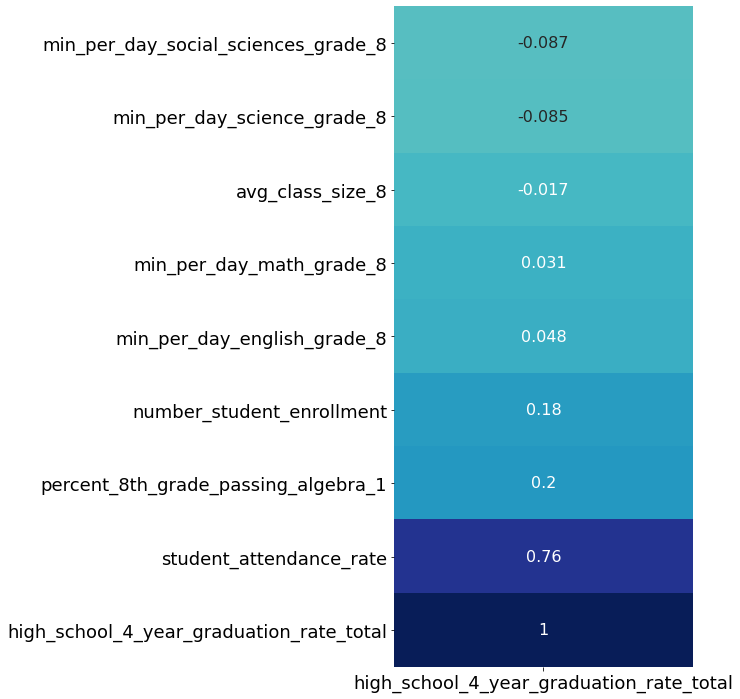

In [136]:
heatmap_numeric_w_dependent_variable(fsm_df, 'high_school_4_year_graduation_rate_total')
plt.tight_layout()
#plt.savefig()
plt.show();

Student attendance rate has the highest correlation. That seems pretty obvious, and that column will contain information for both grade school and high school.
The next two are Percent Passing 8th Grade Algebra I and Number of Student Enrollment.

I will run a linear regression model using these three variables.

In [137]:
formula = 'high_school_4_year_graduation_rate_total~student_attendance_rate+percent_8th_grade_passing_algebra_1+number_student_enrollment'
fsm = ols(formula=formula, data=fsm_df).fit()


In [138]:
fsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                       
====================================================================================================
Dep. Variable:     high_school_4_year_graduation_rate_total   R-squared:                       0.485
Model:                                                  OLS   Adj. R-squared:                  0.465
Method:                                       Least Squares   F-statistic:                     24.51
Date:                                      Wed, 05 Aug 2020   Prob (F-statistic):           2.84e-11
Time:                                              13:29:33   Log-Likelihood:                -278.56
No. Observations:                                        82   AIC:                             565.1
Df Residuals:                                            78   BIC:                             574.7
Df Model:                                                 3                                         
Covariance Type:                                  nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                            -144.6931     28.361     -5.102      0.000    -201.155     -88.231
student_attendance_rate                 2.4501      0.303      8.085      0.000       1.847       3.053
percent_8th_grade_passing_algebra_1     0.0226      0.031      0.738      0.463      -0.038       0.084
number_student_enrollment               0.0018      0.001      1.286      0.202      -0.001       0.005
==============================================================================
Omnibus:                        5.478   Durbin-Watson:                   1.711
Prob(Omnibus):                  0.065   Jarque-Bera (JB):                4.732
Skew:                          -0.548   Prob(JB):                       0.0938
Kurtosis:                       3.429   Cond. No.                     3.07e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [139]:
# rsquared, and params.
# save those values to the variables below.

rsquared = fsm.rsquared
params = fsm.params

print(f'Rsquared of FSM: {rsquared}')
print('----------')
print('Beta values of FSM:')
print(params)

Rsquared of FSM: 0.4852599865523656
----------
Beta values of FSM:
Intercept                             -144.693064
student_attendance_rate                  2.450095
percent_8th_grade_passing_algebra_1      0.022611
number_student_enrollment                0.001774
dtype: float64


It's not pretty but it's a start.

## Second model looking at high school data
Perhaps the 4-year graduation rate of previous cohorts can be used to predict future cohort success?

In [140]:
ssm_df = hs_df[['number_student_enrollment',
                'student_attendance_rate', 
                'high_school_dropout_rate_total',  
                'avg_class_size_high_school', 
                'teacher_retention_rate', 
                'percent_9th_grade_on_track', 
                'chronic_absenteeism', 
                'high_school_4_year_graduation_rate_total']]

In [141]:
ssm_df.shape

(720, 8)

In [142]:
proj_eda(ssm_df)

,null_sum,null_pct,dtypes,count,mean,median,min,max
number_student_enrollment,0,0.000000,int64,720,838.456944,465.0,23.0,4606.0
student_attendance_rate,12,0.016667,float64,708,91.675000,93.5,50.4,98.0
high_school_dropout_rate_total,1,0.001389,float64,719,5.382197,3.5,0.0,53.6
avg_class_size_high_school,9,0.012500,float64,711,19.458650,20.0,2.6,32.4
teacher_retention_rate,12,0.016667,float64,708,83.522458,87.9,0.0,100.0
percent_9th_grade_on_track,38,0.052778,float64,682,85.060704,88.9,0.0,100.0
chronic_absenteeism,16,0.022222,float64,704,28.294034,21.6,1.3,100.0
high_school_4_year_graduation_rate_total,6,0.008333,float64,714,84.853782,88.9,15.4,100.0


In [143]:
ssm_df.corr()['high_school_4_year_graduation_rate_total']

number_student_enrollment                   0.176720
student_attendance_rate                     0.795644
high_school_dropout_rate_total             -0.852619
avg_class_size_high_school                  0.152392
teacher_retention_rate                      0.199569
percent_9th_grade_on_track                  0.300182
chronic_absenteeism                        -0.807025
high_school_4_year_graduation_rate_total    1.000000
Name: high_school_4_year_graduation_rate_total, dtype: float64

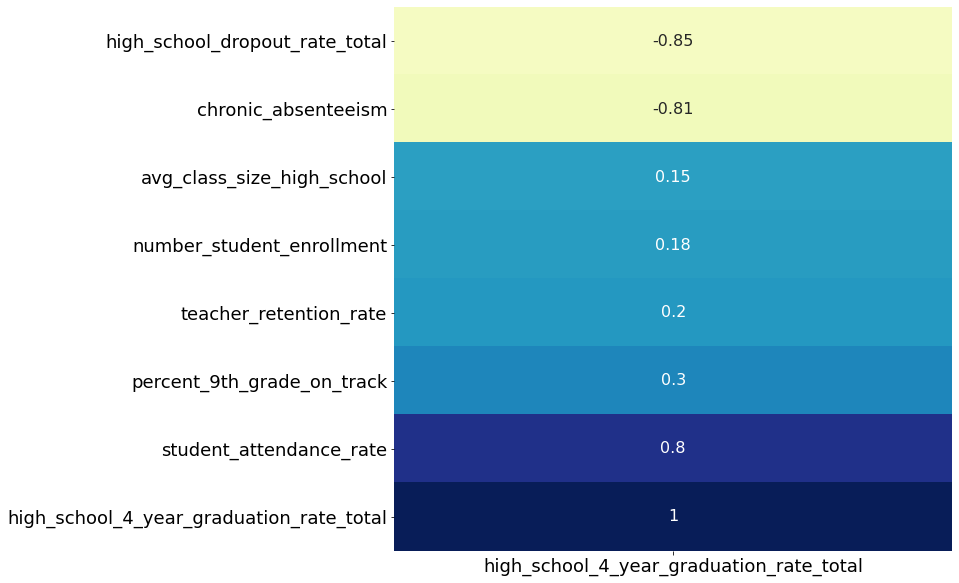

In [144]:
heatmap_numeric_w_dependent_variable(ssm_df, 'high_school_4_year_graduation_rate_total');

In [119]:
outcome = 'high_school_4_year_graduation_rate_total'
predictors = ssm_df.drop('high_school_4_year_graduation_rate_total', axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
model = ols(formula=formula, data=ssm_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                       
====================================================================================================
Dep. Variable:     high_school_4_year_graduation_rate_total   R-squared:                       0.720
Model:                                                  OLS   Adj. R-squared:                  0.717
Method:                                       Least Squares   F-statistic:                     241.3
Date:                                      Wed, 05 Aug 2020   Prob (F-statistic):          7.08e-177
Time:                                              12:36:36   Log-Likelihood:                -2082.5
No. Observations:                                       665   AIC:                             4181.
Df Residuals:                                           657   BIC:                             4217.
Df Model:                                                 7                                         
Covariance Type:                                  nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         56.9297     27.071      2.103      0.036       3.773     110.087
number_student_enrollment          0.0002      0.000      0.583      0.560      -0.000       0.001
student_attendance_rate            0.4103      0.276      1.485      0.138      -0.132       0.953
high_school_dropout_rate_total    -2.0533      0.094    -21.926      0.000      -2.237      -1.869
avg_class_size_high_school        -0.0643      0.056     -1.145      0.253      -0.175       0.046
teacher_retention_rate            -0.0193      0.015     -1.260      0.208      -0.049       0.011
percent_9th_grade_on_track         0.0481      0.021      2.328      0.020       0.008       0.089
chronic_absenteeism               -0.0434      0.057     -0.758      0.449      -0.156       0.069
==============================================================================
Omnibus:                       71.376   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              430.745
Skew:                          -0.215   Prob(JB):                     2.92e-94
Kurtosis:                       6.919   Cond. No.                     1.54e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.54e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### next step, save df as csv to import in new notebook